In [ ]:
!pip install PyMuPDF pdfplumber spacy transformers torch pandas
!python -m spacy download en_core_web_sm

In [ ]:
!pip install   plotly pandas matplotlib seaborn

In [ ]:
#step1
import fitz  # fitz
import pdfplumber
import re
import logging
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass
import os

@dataclass
class ExtractedContent:
    """Data class to store extracted PDF content"""
    raw_text: str
    cleaned_text: str
    pages: List[str]
    metadata: Dict
    extraction_method: str
    success: bool
    error_message: Optional[str] = None

class PDFTextExtractor:
    """
    Comprehensive PDF text extractor for legal contracts
    Handles both text-based and scanned PDFs with multiple extraction methods
    """

    def __init__(self):
        self.setup_logging()

    def setup_logging(self):
        """Setup logging for debugging and monitoring"""
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)

    def extract_text(self, pdf_path: str) -> ExtractedContent:
        """
        Main method to extract text from PDF
        Tries multiple extraction methods for best results
        """
        if not os.path.exists(pdf_path):
            return ExtractedContent(
                raw_text="", cleaned_text="", pages=[], metadata={},
                extraction_method="none", success=False,
                error_message=f"File not found: {pdf_path}"
            )

        self.logger.info(f"Starting text extraction from: {pdf_path}")

        # Try PyMuPDF first (faster and good for most PDFs)
        result = self._extract_with_pymupdf(pdf_path)
        if result.success and self._is_text_meaningful(result.raw_text):
            self.logger.info("Successfully extracted with PyMuPDF")
            return result

        # If PyMuPDF fails or produces poor results, try pdfplumber
        self.logger.info("Trying pdfplumber extraction...")
        result = self._extract_with_pdfplumber(pdf_path)
        if result.success and self._is_text_meaningful(result.raw_text):
            self.logger.info("Successfully extracted with pdfplumber")
            return result

        # If both fail, return the best attempt with error info
        self.logger.warning("Both extraction methods failed or produced poor results")
        return ExtractedContent(
            raw_text="", cleaned_text="", pages=[], metadata={},
            extraction_method="failed", success=False,
            error_message="Unable to extract meaningful text from PDF"
        )

    def _extract_with_pymupdf(self, pdf_path: str) -> ExtractedContent:
        """Extract text using PyMuPDF (fitz)"""
        try:
            doc = fitz.open(pdf_path)
            pages = []
            raw_text = ""

            # Extract metadata
            metadata = {
                "title": doc.metadata.get("title", ""),
                "author": doc.metadata.get("author", ""),
                "subject": doc.metadata.get("subject", ""),
                "creator": doc.metadata.get("creator", ""),
                "producer": doc.metadata.get("producer", ""),
                "creation_date": doc.metadata.get("creationDate", ""),
                "modification_date": doc.metadata.get("modDate", ""),
                "page_count": doc.page_count
            }

            # Extract text from each page
            for page_num in range(doc.page_count):
                page = doc.load_page(page_num)
                page_text = page.get_text()
                pages.append(page_text)
                raw_text += f"\n--- PAGE {page_num + 1} ---\n{page_text}\n"

            doc.close()

            cleaned_text = self._clean_text(raw_text)

            return ExtractedContent(
                raw_text=raw_text,
                cleaned_text=cleaned_text,
                pages=pages,
                metadata=metadata,
                extraction_method="PyMuPDF",
                success=True
            )

        except Exception as e:
            self.logger.error(f"PyMuPDF extraction failed: {str(e)}")
            return ExtractedContent(
                raw_text="", cleaned_text="", pages=[], metadata={},
                extraction_method="PyMuPDF", success=False,
                error_message=str(e)
            )

    def _extract_with_pdfplumber(self, pdf_path: str) -> ExtractedContent:
        """Extract text using pdfplumber (better for complex layouts)"""
        try:
            pages = []
            raw_text = ""
            metadata = {}

            with pdfplumber.open(pdf_path) as pdf:
                # Extract metadata
                if pdf.metadata:
                    metadata = {
                        "title": pdf.metadata.get("Title", ""),
                        "author": pdf.metadata.get("Author", ""),
                        "subject": pdf.metadata.get("Subject", ""),
                        "creator": pdf.metadata.get("Creator", ""),
                        "producer": pdf.metadata.get("Producer", ""),
                        "creation_date": pdf.metadata.get("CreationDate", ""),
                        "modification_date": pdf.metadata.get("ModDate", ""),
                        "page_count": len(pdf.pages)
                    }

                # Extract text from each page
                for page_num, page in enumerate(pdf.pages):
                    page_text = page.extract_text()
                    if page_text:
                        pages.append(page_text)
                        raw_text += f"\n--- PAGE {page_num + 1} ---\n{page_text}\n"

            cleaned_text = self._clean_text(raw_text)

            return ExtractedContent(
                raw_text=raw_text,
                cleaned_text=cleaned_text,
                pages=pages,
                metadata=metadata,
                extraction_method="pdfplumber",
                success=True
            )

        except Exception as e:
            self.logger.error(f"pdfplumber extraction failed: {str(e)}")
            return ExtractedContent(
                raw_text="", cleaned_text="", pages=[], metadata={},
                extraction_method="pdfplumber", success=False,
                error_message=str(e)
            )

    def _clean_text(self, raw_text: str) -> str:
        """
        Clean and preprocess extracted text for legal document analysis
        """
        if not raw_text:
            return ""

        # Remove page separators
        text = re.sub(r'\n--- PAGE \d+ ---\n', '\n\n', raw_text)

        # Fix common OCR/extraction issues
        # Remove excessive whitespace
        text = re.sub(r'\s+', ' ', text)

        # Fix broken words (common in PDFs)
        text = re.sub(r'(\w)-\s*\n\s*(\w)', r'\1\2', text)

        # Normalize quotation marks
        text = re.sub(r'["""]', '"', text)
        text = re.sub(r'[\u2018\u2019\u201A\u201B]', "'", text)

        # Remove unnecessary page breaks and extra newlines
        text = re.sub(r'\n\s*\n\s*\n+', '\n\n', text)

        # Preserve legal formatting patterns
        # Keep numbered sections (1., 2., etc.)
        text = re.sub(r'\n(\d+\.)\s*', r'\n\n\1 ', text)

        # Keep lettered subsections (a), b), etc.)
        text = re.sub(r'\n\s*\(([a-z])\)\s*', r'\n(\1) ', text)

        # Clean up and preserve contract structure
        # Preserve section headers (UPPERCASE words)
        text = re.sub(r'\n([A-Z][A-Z\s]{3,})\n', r'\n\n\1\n\n', text)

        return text.strip()

    def _is_text_meaningful(self, text: str) -> bool:
        """
        Check if extracted text is meaningful (not just garbage characters)
        """
        if not text or len(text.strip()) < 50:
            return False

        # Check ratio of alphabetic characters
        alpha_chars = sum(c.isalpha() for c in text)
        total_chars = len(text.replace(' ', '').replace('\n', ''))

        if total_chars == 0:
            return False

        alpha_ratio = alpha_chars / total_chars

        # Should have at least 60% alphabetic characters for meaningful text
        return alpha_ratio > 0.6

    def get_document_structure(self, content: ExtractedContent) -> Dict:
        """
        Analyze document structure for legal contracts
        """
        if not content.success:
            return {}

        structure = {
            "total_pages": len(content.pages),
            "total_words": len(content.cleaned_text.split()),
            "total_characters": len(content.cleaned_text),
            "sections": self._identify_sections(content.cleaned_text),
            "potential_parties": self._identify_potential_parties(content.cleaned_text),
            "dates_found": self._extract_dates(content.cleaned_text),
            "financial_terms": self._identify_financial_terms(content.cleaned_text)
        }

        return structure

    def _identify_sections(self, text: str) -> List[str]:
        """Identify major sections in the legal document"""
        # Common legal document sections
        section_patterns = [
            r'\b(RECITALS?|WHEREAS)\b',
            r'\b(DEFINITIONS?|TERMS?)\b',
            r'\b(SCOPE OF WORK|SERVICES?)\b',
            r'\b(PAYMENT|COMPENSATION|FEES?)\b',
            r'\b(TERMINATION|TERM)\b',
            r'\b(CONFIDENTIALITY|NON-DISCLOSURE)\b',
            r'\b(LIABILITY|INDEMNIFICATION)\b',
            r'\b(INTELLECTUAL PROPERTY|IP RIGHTS?)\b',
            r'\b(GOVERNING LAW|JURISDICTION)\b',
            r'\b(SIGNATURES?|EXECUTION)\b'
        ]

        found_sections = []
        for pattern in section_patterns:
            matches = re.findall(pattern, text, re.IGNORECASE)
            found_sections.extend(matches)

        return list(set(found_sections))

    def _identify_potential_parties(self, text: str) -> List[str]:
        """Identify potential contracting parties"""
        # Look for company names, legal entities
        party_patterns = [
            r'\b([A-Z][a-zA-Z\s]+(?:Inc\.?|LLC|Corp\.?|Corporation|Ltd\.?|Limited|LP|LLP))\b',
            r'\b([A-Z][a-zA-Z\s]+ Company)\b'
        ]

        parties = []
        for pattern in party_patterns:
            matches = re.findall(pattern, text)
            parties.extend(matches)

        return list(set(parties))

    def _extract_dates(self, text: str) -> List[str]:
        """Extract potential dates from the document"""
        date_patterns = [
            r'\b\d{1,2}/\d{1,2}/\d{4}\b',  # MM/DD/YYYY
            r'\b\d{1,2}-\d{1,2}-\d{4}\b',  # MM-DD-YYYY
            r'\b(?:January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{1,2},?\s+\d{4}\b',
            r'\b\d{1,2}\s+(?:January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{4}\b'
        ]

        dates = []
        for pattern in date_patterns:
            matches = re.findall(pattern, text, re.IGNORECASE)
            dates.extend(matches)

        return list(set(dates))

    def _identify_financial_terms(self, text: str) -> List[str]:
        """Identify financial terms and amounts"""
        financial_patterns = [
            r'\$[\d,]+\.?\d*',  # Dollar amounts
            r'\b\d+%\b',  # Percentages
            r'\b(?:payment|fee|cost|price|amount|salary|wage)\s+of\s+\$?[\d,]+\.?\d*\b'
        ]

        financial_terms = []
        for pattern in financial_patterns:
            matches = re.findall(pattern, text, re.IGNORECASE)
            financial_terms.extend(matches)

        return list(set(financial_terms))

# Example usage and testing
def main():
    """Example usage of the PDF extractor"""
    extractor = PDFTextExtractor()

    # Replace with your PDF path
    pdf_path = "/content/Law_Insider_encore-capital-group-inc_among_Filed_02-07-2004_Contract.pdf"  # Change this to your PDF file path

    print("Starting PDF extraction...")
    result = extractor.extract_text(pdf_path)

    if result.success:
        print(f"✅ Extraction successful using {result.extraction_method}")
        print(f"📄 Pages extracted: {len(result.pages)}")
        print(f"📝 Total characters: {len(result.cleaned_text)}")
        print(f"🔍 Metadata: {result.metadata}")

        # Analyze document structure
        structure = extractor.get_document_structure(result)
        print(f"\n📊 Document Analysis:")
        print(f"   Total words: {structure.get('total_words', 0)}")
        print(f"   Sections found: {structure.get('sections', [])}")
        print(f"   Potential parties: {structure.get('potential_parties', [])}")
        print(f"   Dates found: {structure.get('dates_found', [])}")
        print(f"   Financial terms: {structure.get('financial_terms', [])}")

        # Show first 500 characters of cleaned text
        print(f"\n📄 Sample extracted text:")
        print("-" * 50)
        print(result.cleaned_text[:500] + "..." if len(result.cleaned_text) > 500 else result.cleaned_text)

    else:
        print(f"❌ Extraction failed: {result.error_message}")

if __name__ == "__main__":
    main()

Starting PDF extraction...
✅ Extraction successful using PyMuPDF
📄 Pages extracted: 38
📝 Total characters: 309973
🔍 Metadata: {'title': '', 'author': '', 'subject': '', 'creator': 'Chromium', 'producer': 'Skia/PDF m76', 'creation_date': "D:20191015114016+00'00'", 'modification_date': "D:20191015114016+00'00'", 'page_count': 38}

📊 Document Analysis:
   Total words: 46879
   Sections found: ['Terms', 'indemnification', 'compensation', 'Services', 'payment', 'SIGNATURE', 'fee', 'execution', 'definitions', 'Confidentiality', 'term', 'Signature', 'services', 'Termination', 'Liability', 'Recitals', 'signature', 'Service', 'Signatures', 'Fee', 'confidentiality', 'liability', 'DEFINITIONS', 'terms', 'Payment', 'Fees', 'definition', 'service', 'JURISDICTION', 'termination', 'intellectual property', 'Execution', 'signatures', 'fees', 'Intellectual Property', 'Indemnification', 'EXECUTION', 'jurisdiction']
   Potential parties: ['WOOD LLP', 'MRC Receivables Corporation and CFSC Capital Corp', 'I

In [ ]:
#step2
import re
import json
import logging
from typing import Dict, List, Optional, Set, Tuple
from dataclasses import dataclass
from enum import Enum
import os

# Import from Step 1
# from step1_pdf_extractor import ExtractedContent, PDFTextExtractor

class ContractType(Enum):
    """Enumeration of contract types"""
    SERVICE_AGREEMENT = "Service Agreement"
    NDA = "Non-Disclosure Agreement"
    EMPLOYMENT = "Employment Contract"
    CONSULTING = "Consulting Agreement"
    LEASE = "Lease Agreement"
    PURCHASE = "Purchase Agreement"
    PARTNERSHIP = "Partnership Agreement"
    LICENSE = "License Agreement"
    VENDOR = "Vendor Agreement"
    GENERAL = "General Contract"

class ClauseType(Enum):
    """Enumeration of legal clause types"""
    TERMINATION = "Termination"
    PAYMENT = "Payment"
    LIABILITY = "Liability"
    CONFIDENTIALITY = "Confidentiality"
    INTELLECTUAL_PROPERTY = "Intellectual Property"
    INDEMNIFICATION = "Indemnification"
    GOVERNING_LAW = "Governing Law"
    FORCE_MAJEURE = "Force Majeure"
    DISPUTE_RESOLUTION = "Dispute Resolution"
    SCOPE_OF_WORK = "Scope of Work"

@dataclass
class LegalTerm:
    """Data class for individual legal terms"""
    term: str
    category: str
    contract_types: List[ContractType]
    clause_type: Optional[ClauseType]
    synonyms: List[str]
    context_keywords: List[str]
    importance_score: int  # 1-10, 10 being most important

@dataclass
class AnalyzedLegalContent:
    """Data class for analyzed legal content"""
    contract_type: ContractType
    identified_clauses: Dict[ClauseType, List[str]]
    parties: List[str]
    key_terms: Dict[str, List[str]]
    financial_terms: Dict[str, str]
    dates: Dict[str, str]
    obligations: List[str]
    risks: List[str]
    missing_clauses: List[ClauseType]
    confidence_score: float

class LegalKnowledgeBase:
    """
    Comprehensive legal knowledge base for contract analysis
    Integrates with Step 1 PDF extractor
    """

    def __init__(self):
        self.setup_logging()
        self.legal_terms = {}
        self.contract_patterns = {}
        self.clause_patterns = {}
        self._initialize_knowledge_base()

    def setup_logging(self):
        """Setup logging consistent with Step 1"""
        self.logger = logging.getLogger(__name__)

    def _initialize_knowledge_base(self):
        """Initialize all legal dictionaries and knowledge base"""
        self._load_legal_terms()
        self._load_contract_patterns()
        self._load_clause_patterns()
        self.logger.info("Legal knowledge base initialized successfully")

    def _load_legal_terms(self):
        """Load comprehensive legal terms dictionary"""

        # Payment and Financial Terms
        payment_terms = [
            LegalTerm("payment", "financial", [ContractType.SERVICE_AGREEMENT, ContractType.CONSULTING],
                     ClauseType.PAYMENT, ["compensation", "remuneration", "fee", "salary"],
                     ["due", "payable", "amount", "invoice"], 9),
            LegalTerm("invoice", "financial", [ContractType.SERVICE_AGREEMENT, ContractType.VENDOR],
                     ClauseType.PAYMENT, ["bill", "statement", "charge"],
                     ["submit", "approve", "pay"], 7),
            LegalTerm("interest", "financial", [ContractType.GENERAL],
                     ClauseType.PAYMENT, ["penalty", "late fee", "finance charge"],
                     ["overdue", "default", "rate"], 6),
            LegalTerm("retainer", "financial", [ContractType.CONSULTING, ContractType.SERVICE_AGREEMENT],
                     ClauseType.PAYMENT, ["advance", "deposit"],
                     ["upfront", "initial"], 5),
        ]

        # Termination Terms
        termination_terms = [
            LegalTerm("termination", "contract_lifecycle", [ContractType.GENERAL],
                     ClauseType.TERMINATION, ["terminate", "end", "cancel", "dissolution"],
                     ["notice", "breach", "cause", "convenience"], 10),
            LegalTerm("breach", "contract_lifecycle", [ContractType.GENERAL],
                     ClauseType.TERMINATION, ["violation", "default", "non-compliance"],
                     ["material", "cure", "remedy"], 9),
            LegalTerm("notice", "contract_lifecycle", [ContractType.GENERAL],
                     ClauseType.TERMINATION, ["notification", "written notice"],
                     ["days", "prior", "written"], 8),
            LegalTerm("cure period", "contract_lifecycle", [ContractType.GENERAL],
                     ClauseType.TERMINATION, ["remedy period", "grace period"],
                     ["days to cure", "opportunity"], 7),
        ]

        # Liability Terms
        liability_terms = [
            LegalTerm("liability", "risk", [ContractType.GENERAL],
                     ClauseType.LIABILITY, ["responsibility", "obligation", "accountability"],
                     ["limited", "unlimited", "joint", "several"], 10),
            LegalTerm("indemnification", "risk", [ContractType.GENERAL],
                     ClauseType.INDEMNIFICATION, ["indemnify", "hold harmless", "defend"],
                     ["losses", "damages", "claims"], 9),
            LegalTerm("limitation of liability", "risk", [ContractType.SERVICE_AGREEMENT],
                     ClauseType.LIABILITY, ["cap on damages", "liability cap"],
                     ["shall not exceed", "maximum"], 8),
            LegalTerm("consequential damages", "risk", [ContractType.GENERAL],
                     ClauseType.LIABILITY, ["indirect damages", "special damages"],
                     ["exclude", "waive", "disclaim"], 7),
        ]

        # Confidentiality Terms
        confidentiality_terms = [
            LegalTerm("confidential information", "data_protection", [ContractType.NDA, ContractType.EMPLOYMENT],
                     ClauseType.CONFIDENTIALITY, ["proprietary information", "trade secrets"],
                     ["disclose", "protect", "return"], 10),
            LegalTerm("non-disclosure", "data_protection", [ContractType.NDA],
                     ClauseType.CONFIDENTIALITY, ["NDA", "confidentiality agreement"],
                     ["obligation", "duty"], 9),
            LegalTerm("trade secret", "data_protection", [ContractType.EMPLOYMENT, ContractType.NDA],
                     ClauseType.CONFIDENTIALITY, ["proprietary", "confidential"],
                     ["protect", "maintain"], 8),
        ]

        # Intellectual Property Terms
        ip_terms = [
            LegalTerm("intellectual property", "ip", [ContractType.SERVICE_AGREEMENT, ContractType.EMPLOYMENT],
                     ClauseType.INTELLECTUAL_PROPERTY, ["IP", "intangible assets"],
                     ["ownership", "rights", "license"], 10),
            LegalTerm("copyright", "ip", [ContractType.SERVICE_AGREEMENT],
                     ClauseType.INTELLECTUAL_PROPERTY, ["author rights"],
                     ["work for hire", "ownership"], 8),
            LegalTerm("patent", "ip", [ContractType.LICENSE],
                     ClauseType.INTELLECTUAL_PROPERTY, ["invention"],
                     ["application", "granted"], 7),
            LegalTerm("trademark", "ip", [ContractType.LICENSE],
                     ClauseType.INTELLECTUAL_PROPERTY, ["service mark", "brand"],
                     ["registration", "use"], 7),
        ]

        # Governing Law Terms
        legal_terms = [
            LegalTerm("governing law", "jurisdiction", [ContractType.GENERAL],
                     ClauseType.GOVERNING_LAW, ["applicable law", "choice of law"],
                     ["state", "jurisdiction", "courts"], 8),
            LegalTerm("jurisdiction", "jurisdiction", [ContractType.GENERAL],
                     ClauseType.GOVERNING_LAW, ["venue", "forum"],
                     ["courts", "disputes"], 8),
            LegalTerm("arbitration", "dispute", [ContractType.GENERAL],
                     ClauseType.DISPUTE_RESOLUTION, ["binding arbitration"],
                     ["AAA", "JAMS", "rules"], 7),
        ]

        # Force Majeure Terms
        force_majeure_terms = [
            LegalTerm("force majeure", "risk", [ContractType.GENERAL],
                     ClauseType.FORCE_MAJEURE, ["act of god", "unforeseeable circumstances"],
                     ["pandemic", "war", "natural disaster"], 6),
        ]

        # Combine all terms
        all_terms = (payment_terms + termination_terms + liability_terms +
                    confidentiality_terms + ip_terms + legal_terms + force_majeure_terms)

        # Index by term name for quick lookup
        for term in all_terms:
            self.legal_terms[term.term.lower()] = term
            # Also index synonyms
            for synonym in term.synonyms:
                self.legal_terms[synonym.lower()] = term

    def _load_contract_patterns(self):
        """Load patterns to identify contract types"""
        self.contract_patterns = {
            ContractType.SERVICE_AGREEMENT: [
                r'\b(service agreement|services agreement)\b',
                r'\b(statement of work|SOW)\b',
                r'\b(professional services|consulting services)\b',
                r'\b(scope of services|services to be provided)\b'
            ],
            ContractType.NDA: [
                r'\b(non.?disclosure agreement|NDA)\b',
                r'\b(confidentiality agreement)\b',
                r'\b(mutual non.?disclosure)\b'
            ],
            ContractType.EMPLOYMENT: [
                r'\b(employment agreement|employment contract)\b',
                r'\b(offer letter|employment offer)\b',
                r'\b(employee handbook)\b'
            ],
            ContractType.CONSULTING: [
                r'\b(consulting agreement|consultant agreement)\b',
                r'\b(independent contractor agreement)\b',
                r'\b(freelance agreement)\b'
            ],
            ContractType.LEASE: [
                r'\b(lease agreement|rental agreement)\b',
                r'\b(landlord|tenant|lessor|lessee)\b'
            ],
            ContractType.PURCHASE: [
                r'\b(purchase agreement|sale agreement)\b',
                r'\b(buyer|seller|purchaser|vendor)\b'
            ],
            ContractType.VENDOR: [
                r'\b(vendor agreement|supplier agreement)\b',
                r'\b(procurement contract)\b'
            ]
        }

    def _load_clause_patterns(self):
        """Load patterns to identify specific clauses"""
        self.clause_patterns = {
            ClauseType.TERMINATION: [
                r'\b(termination|terminate|end this agreement)\b',
                r'\b(upon termination|after termination)\b',
                r'\b(breach|default|violation)\b',
                r'\b(notice of termination|termination notice)\b'
            ],
            ClauseType.PAYMENT: [
                r'\b(payment|compensation|fee|remuneration)\b',
                r'\b(invoice|bill|statement)\b',
                r'\b(due date|payment terms|net \d+)\b',
                r'\b(\$[\d,]+|\d+\s*dollars?)\b'
            ],
            ClauseType.LIABILITY: [
                r'\b(liability|liable|responsible for)\b',
                r'\b(limitation of liability|liability cap)\b',
                r'\b(consequential damages|indirect damages)\b',
                r'\b(exclude|disclaim|waive)\b'
            ],
            ClauseType.CONFIDENTIALITY: [
                r'\b(confidential|proprietary|trade secret)\b',
                r'\b(non.?disclosure|NDA)\b',
                r'\b(confidentiality obligation)\b'
            ],
            ClauseType.INTELLECTUAL_PROPERTY: [
                r'\b(intellectual property|IP|copyright|patent|trademark)\b',
                r'\b(work for hire|ownership of work)\b',
                r'\b(license|licensing)\b'
            ],
            ClauseType.INDEMNIFICATION: [
                r'\b(indemnif\w+|hold harmless|defend)\b',
                r'\b(losses|damages|claims|suits)\b'
            ],
            ClauseType.GOVERNING_LAW: [
                r'\b(governing law|applicable law|choice of law)\b',
                r'\b(jurisdiction|venue|courts?)\b',
                r'\b(state of|laws of)\b'
            ],
            ClauseType.DISPUTE_RESOLUTION: [
                r'\b(arbitration|mediation|dispute resolution)\b',
                r'\b(AAA|JAMS|arbitrator)\b'
            ],
            ClauseType.FORCE_MAJEURE: [
                r'\b(force majeure|act of god)\b',
                r'\b(unforeseeable|beyond.*control)\b'
            ]
        }

    def analyze_legal_content(self, extracted_content: ExtractedContent) -> AnalyzedLegalContent:
        """
        Main method to analyze extracted content using legal knowledge base
        """
        if not extracted_content.success:
            self.logger.error("Cannot analyze - PDF extraction failed")
            return self._create_empty_analysis()

        self.logger.info("Starting legal content analysis...")

        text = extracted_content.cleaned_text.lower()

        # Identify contract type
        contract_type = self._identify_contract_type(text)

        # Identify clauses
        identified_clauses = self._identify_clauses(text)

        # Extract parties (enhanced from Step 1)
        parties = self._extract_parties(extracted_content.cleaned_text)

        # Categorize terms
        key_terms = self._categorize_terms(text)

        # Enhanced financial analysis
        financial_terms = self._analyze_financial_terms(extracted_content.cleaned_text)

        # Enhanced date analysis
        dates = self._analyze_dates(extracted_content.cleaned_text)

        # Extract obligations
        obligations = self._extract_obligations(extracted_content.cleaned_text)

        # Identify risks
        risks = self._identify_risks(text, identified_clauses)

        # Check for missing clauses
        missing_clauses = self._check_missing_clauses(contract_type, identified_clauses)

        # Calculate confidence score
        confidence_score = self._calculate_confidence_score(
            contract_type, identified_clauses, parties, key_terms
        )

        analysis = AnalyzedLegalContent(
            contract_type=contract_type,
            identified_clauses=identified_clauses,
            parties=parties,
            key_terms=key_terms,
            financial_terms=financial_terms,
            dates=dates,
            obligations=obligations,
            risks=risks,
            missing_clauses=missing_clauses,
            confidence_score=confidence_score
        )

        self.logger.info(f"Legal analysis completed with confidence: {confidence_score:.2f}")
        return analysis

    def _identify_contract_type(self, text: str) -> ContractType:
        """Identify the type of contract"""
        scores = {}

        for contract_type, patterns in self.contract_patterns.items():
            score = 0
            for pattern in patterns:
                matches = len(re.findall(pattern, text, re.IGNORECASE))
                score += matches
            scores[contract_type] = score

        # Return the contract type with highest score, default to GENERAL
        if scores and max(scores.values()) > 0:
            return max(scores, key=scores.get)
        return ContractType.GENERAL

    def _identify_clauses(self, text: str) -> Dict[ClauseType, List[str]]:
        """Identify legal clauses in the text"""
        identified_clauses = {}

        for clause_type, patterns in self.clause_patterns.items():
            matches = []
            for pattern in patterns:
                found = re.findall(pattern, text, re.IGNORECASE)
                matches.extend(found)

            if matches:
                identified_clauses[clause_type] = list(set(matches))

        return identified_clauses

    def _extract_parties(self, text: str) -> List[str]:
        """Enhanced party extraction"""
        party_patterns = [
            r'\b([A-Z][a-zA-Z\s]+(?:Inc\.?|LLC|Corp\.?|Corporation|Ltd\.?|Limited|LP|LLP|Co\.?))\b',
            r'\b([A-Z][a-zA-Z\s]+ Company)\b',
            r'\b(The [A-Z][a-zA-Z\s]+ (?:Inc\.?|LLC|Corp\.?|Corporation))\b',
            r'"([^"]+)"(?:\s*\([^)]*\))?(?:\s*,?\s*(?:a|an)\s+[^,\n]+)?',  # Quoted names
        ]

        parties = set()
        for pattern in party_patterns:
            matches = re.findall(pattern, text)
            for match in matches:
                if isinstance(match, tuple):
                    match = match[0] if match[0] else match[1]
                if len(match.strip()) > 2 and not match.lower() in ['the', 'and', 'or']:
                    parties.add(match.strip())

        return list(parties)[:10]  # Limit to 10 most likely parties

    def _categorize_terms(self, text: str) -> Dict[str, List[str]]:
        """Categorize identified legal terms"""
        categories = {}

        for term_name, term_obj in self.legal_terms.items():
            if term_name in text:
                category = term_obj.category
                if category not in categories:
                    categories[category] = []
                categories[category].append(term_obj.term)

        # Remove duplicates
        for category in categories:
            categories[category] = list(set(categories[category]))

        return categories

    def _analyze_financial_terms(self, text: str) -> Dict[str, str]:
        """Enhanced financial term analysis"""
        financial_analysis = {}

        # Payment amounts
        amounts = re.findall(r'\$[\d,]+\.?\d*', text)
        if amounts:
            financial_analysis['amounts'] = amounts

        # Payment terms
        payment_terms = re.findall(r'\bnet\s+(\d+)\b', text, re.IGNORECASE)
        if payment_terms:
            financial_analysis['payment_terms'] = f"Net {payment_terms[0]} days"

        # Interest rates
        rates = re.findall(r'(\d+(?:\.\d+)?)\s*%', text)
        if rates:
            financial_analysis['rates'] = rates

        # Late fees
        late_fee_patterns = [
            r'late\s+fee.*?(\$[\d,]+\.?\d*)',
            r'interest.*?(\d+(?:\.\d+)?)\s*%'
        ]
        for pattern in late_fee_patterns:
            matches = re.findall(pattern, text, re.IGNORECASE)
            if matches:
                financial_analysis['late_fees'] = matches
                break

        return financial_analysis

    def _analyze_dates(self, text: str) -> Dict[str, str]:
        """Enhanced date analysis with context"""
        date_analysis = {}

        # Common date contexts
        date_contexts = {
            'effective_date': [r'effective\s+(?:date|as of)\s*:?\s*([^.\n]+)', r'this agreement.*effective\s*([^.\n]+)'],
            'expiration_date': [r'expir\w+.*?([^.\n]+)', r'term.*end\w*.*?([^.\n]+)'],
            'termination_notice': [r'(\d+)\s*days?\s*(?:prior\s*)?notice', r'notice.*?(\d+)\s*days?'],
            'signature_date': [r'dated?\s*:?\s*([^.\n]+)', r'signed.*?([^.\n]+)']
        }

        for context, patterns in date_contexts.items():
            for pattern in patterns:
                matches = re.findall(pattern, text, re.IGNORECASE)
                if matches:
                    date_analysis[context] = matches[0]
                    break

        return date_analysis

    def _extract_obligations(self, text: str) -> List[str]:
        """Extract key obligations from the contract"""
        obligation_patterns = [
            r'(?:shall|must|will|agrees? to)\s+([^.\n]{10,100})',
            r'(?:responsible for|obligated to|required to)\s+([^.\n]{10,100})',
            r'(?:duty to|obligation to)\s+([^.\n]{10,100})'
        ]

        obligations = []
        for pattern in obligation_patterns:
            matches = re.findall(pattern, text, re.IGNORECASE)
            obligations.extend([match.strip() for match in matches])

        return list(set(obligations))[:20]  # Limit to 20 key obligations

    def _identify_risks(self, text: str, clauses: Dict[ClauseType, List[str]]) -> List[str]:
        """Identify potential risks in the contract"""
        risks = []

        # Check for missing liability limitations
        if ClauseType.LIABILITY not in clauses:
            risks.append("No liability limitation clause found")

        # Check for unlimited liability
        if 'unlimited liability' in text:
            risks.append("Contract contains unlimited liability terms")

        # Check for automatic renewal
        if re.search(r'automatic\w*\s+renew\w*', text, re.IGNORECASE):
            risks.append("Contract has automatic renewal clause")

        # Check for exclusive obligations
        if re.search(r'exclusiv\w+', text, re.IGNORECASE):
            risks.append("Contract contains exclusivity obligations")

        # Check for broad indemnification
        if re.search(r'indemnif\w+.*(?:all|any|every)', text, re.IGNORECASE):
            risks.append("Broad indemnification obligations present")

        return risks

    def _check_missing_clauses(self, contract_type: ContractType,
                              identified_clauses: Dict[ClauseType, List[str]]) -> List[ClauseType]:
        """Check for commonly missing clauses based on contract type"""
        required_clauses = {
            ContractType.SERVICE_AGREEMENT: [
                ClauseType.TERMINATION, ClauseType.PAYMENT, ClauseType.LIABILITY,
                ClauseType.INTELLECTUAL_PROPERTY, ClauseType.GOVERNING_LAW
            ],
            ContractType.NDA: [
                ClauseType.CONFIDENTIALITY, ClauseType.TERMINATION, ClauseType.GOVERNING_LAW
            ],
            ContractType.EMPLOYMENT: [
                ClauseType.TERMINATION, ClauseType.PAYMENT, ClauseType.CONFIDENTIALITY,
                ClauseType.INTELLECTUAL_PROPERTY
            ],
            ContractType.GENERAL: [
                ClauseType.TERMINATION, ClauseType.GOVERNING_LAW, ClauseType.LIABILITY
            ]
        }

        required = required_clauses.get(contract_type, required_clauses[ContractType.GENERAL])
        missing = [clause for clause in required if clause not in identified_clauses]

        return missing

    def _calculate_confidence_score(self, contract_type: ContractType,
                                   clauses: Dict[ClauseType, List[str]],
                                   parties: List[str], key_terms: Dict[str, List[str]]) -> float:
        """Calculate confidence score for the analysis"""
        score = 0.0

        # Contract type identification (30%)
        if contract_type != ContractType.GENERAL:
            score += 0.3
        else:
            score += 0.1

        # Clause identification (40%)
        clause_score = min(len(clauses) / 5.0, 1.0) * 0.4
        score += clause_score

        # Party identification (15%)
        if parties:
            party_score = min(len(parties) / 2.0, 1.0) * 0.15
            score += party_score

        # Term categorization (15%)
        if key_terms:
            term_score = min(len(key_terms) / 3.0, 1.0) * 0.15
            score += term_score

        return min(score, 1.0)

    def _create_empty_analysis(self) -> AnalyzedLegalContent:
        """Create empty analysis for failed extractions"""
        return AnalyzedLegalContent(
            contract_type=ContractType.GENERAL,
            identified_clauses={},
            parties=[],
            key_terms={},
            financial_terms={},
            dates={},
            obligations=[],
            risks=["Unable to analyze document"],
            missing_clauses=[],
            confidence_score=0.0
        )

    def export_analysis_summary(self, analysis: AnalyzedLegalContent) -> Dict:
        """Export analysis in a structured format for Step 3"""
        return {
            "contract_analysis": {
                "type": analysis.contract_type.value,
                "confidence": analysis.confidence_score,
                "parties": analysis.parties,
                "key_clauses": {k.value: v for k, v in analysis.identified_clauses.items()},
                "financial_terms": analysis.financial_terms,
                "important_dates": analysis.dates,
                "obligations": analysis.obligations,
                "identified_risks": analysis.risks,
                "missing_clauses": [clause.value for clause in analysis.missing_clauses],
                "legal_term_categories": analysis.key_terms
            }
        }

# Integration function for Step 1 + Step 2
def analyze_contract_pdf(pdf_path: str) -> Dict:
    """
    Complete function that combines Step 1 extraction with Step 2 analysis
    """
    # Step 1: Extract content
    extractor = PDFTextExtractor()
    extracted_content = extractor.extract_text(pdf_path)

    if not extracted_content.success:
        return {"error": f"Failed to extract PDF content: {extracted_content.error_message}"}

    # Step 2: Analyze content
    knowledge_base = LegalKnowledgeBase()
    analysis = knowledge_base.analyze_legal_content(extracted_content)

    # Return structured analysis
    return knowledge_base.export_analysis_summary(analysis)

# Example usage
def main():
    """Example usage combining Step 1 and Step 2"""
    pdf_path = "/content/SampleContract-Shuttle.pdf"  # Your PDF path

    print("🔍 Analyzing contract PDF...")
    result = analyze_contract_pdf(pdf_path)

    if "error" in result:
        print(f"❌ Analysis failed: {result['error']}")
        return

    analysis = result["contract_analysis"]

    print(f"\n📋 CONTRACT ANALYSIS RESULTS")
    print("=" * 50)
    print(f"📄 Contract Type: {analysis['type']}")
    print(f"🎯 Confidence Score: {analysis['confidence']:.2f}")
    print(f"👥 Parties: {', '.join(analysis['parties'])}")
    print(f"\n📑 Identified Clauses:")
    for clause_type, terms in analysis['key_clauses'].items():
        print(f"   • {clause_type}: {len(terms)} instances")

    print(f"\n💰 Financial Terms:")
    for term_type, values in analysis['financial_terms'].items():
        print(f"   • {term_type}: {values}")

    print(f"\n📅 Important Dates:")
    for date_type, date_value in analysis['important_dates'].items():
        print(f"   • {date_type}: {date_value}")

    print(f"\n⚠️ Identified Risks ({len(analysis['identified_risks'])}):")
    for risk in analysis['identified_risks']:
        print(f"   • {risk}")

    print(f"\n❌ Missing Clauses ({len(analysis['missing_clauses'])}):")
    for clause in analysis['missing_clauses']:
        print(f"   • {clause}")

    print(f"\n🏷️ Legal Term Categories:")
    for category, terms in analysis['legal_term_categories'].items():
        print(f"   • {category}: {len(terms)} terms")

if __name__ == "__main__":
    main()

🔍 Analyzing contract PDF...

📋 CONTRACT ANALYSIS RESULTS
📄 Contract Type: Service Agreement
🎯 Confidence Score: 1.00
👥 Parties: deliverables, PRINTED PRINTED Company

📑 Identified Clauses:
   • Termination: 5 instances
   • Payment: 5 instances
   • Liability: 3 instances
   • Confidentiality: 1 instances
   • Intellectual Property: 4 instances
   • Indemnification: 7 instances
   • Governing Law: 3 instances

💰 Financial Terms:
   • amounts: ['$1,000,000', '$1,000,000', '$1,000,000', '$50,000', '$25,000', '$25,000', '$25,000']
   • rates: ['100']

📅 Important Dates:
   • effective_date: of this Agreement with Certificates of Insurance for all required coverages
   • expiration_date:  of this Agreement (hereinafter “post agreement coverage”) and any extensions thereof
   • termination_notice: 30
   • signature_date: ); contingent upon prior approval by the COMMISSION governing board, and the CONSULTANT shall commence work after notification to proceed by the COMMISSION'S Contract Manag

📋 Legal Contract Analyzer - Demo Mode
📁 Make sure to upload your PDF file to Colab first!
📝 Then update the pdf_path variable with your file path

🚀 Starting Complete Legal Contract Analysis...


## 👥 Contracting Parties & Document Type

## 📑 Clause Analysis

## 💰 Financial Terms Analysis

## ⚠️ Risk Assessment

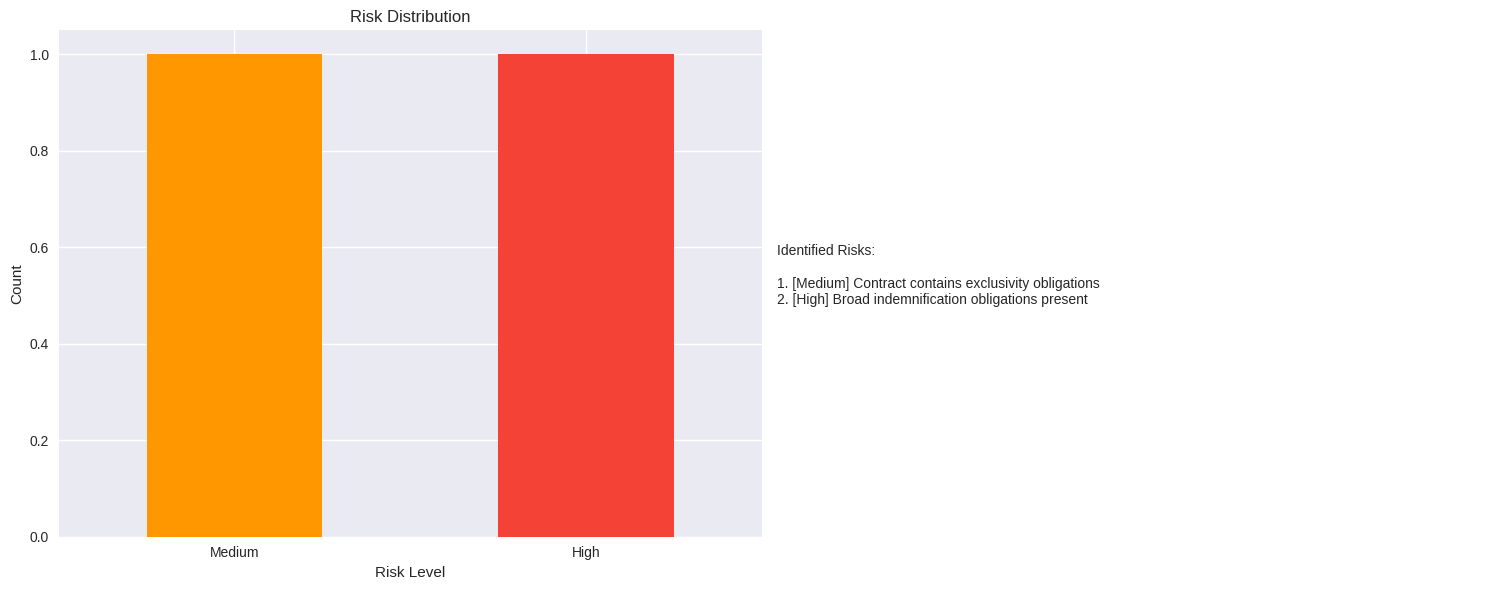

## 📅 Timeline Analysis

## 💡 Recommendations


✅ Analysis Complete!
📊 Interactive visualizations displayed above
💡 Scroll up to see the full analysis report


In [ ]:
#step3
# Interactive Legal Contract Analyzer for Google Colab
# Integrates with your existing Step 1 & Step 2 code

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, Markdown
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set up styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class LegalContractVisualizer:
    """
    Interactive visualization system for legal contract analysis
    Designed for Google Colab environment
    """

    def __init__(self):
        self.setup_styling()

    def setup_styling(self):
        """Setup custom CSS styling for better display"""
        display(HTML("""
        <style>
        .contract-header {
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            padding: 20px;
            border-radius: 10px;
            margin: 10px 0;
            text-align: center;
            font-family: 'Arial', sans-serif;
        }
        .analysis-section {
            background: #f8f9fa;
            border-left: 4px solid #007bff;
            padding: 15px;
            margin: 10px 0;
            border-radius: 5px;
        }
        .risk-high { background: #ffebee; border-left-color: #f44336; }
        .risk-medium { background: #fff3e0; border-left-color: #ff9800; }
        .risk-low { background: #e8f5e8; border-left-color: #4caf50; }
        .clause-found { color: #4caf50; font-weight: bold; }
        .clause-missing { color: #f44336; font-weight: bold; }
        .confidence-high { color: #4caf50; }
        .confidence-medium { color: #ff9800; }
        .confidence-low { color: #f44336; }
        </style>
        """))

    def display_analysis_results(self, analysis_result):
        """
        Main function to display comprehensive analysis results
        """
        if "error" in analysis_result:
            self._display_error(analysis_result["error"])
            return

        analysis = analysis_result["contract_analysis"]

        # Header
        self._display_header(analysis)

        # Overview Dashboard
        self._display_overview_dashboard(analysis)

        # Detailed Analysis Sections
        self._display_parties_and_type(analysis)
        self._display_clause_analysis(analysis)
        self._display_financial_analysis(analysis)
        self._display_risk_assessment(analysis)
        self._display_timeline_analysis(analysis)
        self._display_recommendations(analysis)

    def _display_error(self, error_message):
        """Display error message"""
        display(HTML(f"""
        <div style="background: #ffebee; border: 2px solid #f44336; padding: 20px; border-radius: 10px; margin: 10px 0;">
            <h3 style="color: #f44336; margin: 0;">❌ Analysis Failed</h3>
            <p style="margin: 10px 0 0 0; color: #333;">{error_message}</p>
        </div>
        """))

    def _display_header(self, analysis):
        """Display main header with key metrics"""
        confidence_class = self._get_confidence_class(analysis['confidence'])

        display(HTML(f"""
        <div class="contract-header">
            <h1>📋 Legal Contract Analysis Report</h1>
            <div style="display: flex; justify-content: space-around; margin-top: 20px; flex-wrap: wrap;">
                <div>
                    <h3>Contract Type</h3>
                    <p style="font-size: 18px; margin: 5px 0;">{analysis['type']}</p>
                </div>
                <div>
                    <h3>Confidence Score</h3>
                    <p style="font-size: 18px; margin: 5px 0;" class="{confidence_class}">
                        {analysis['confidence']:.1%}
                    </p>
                </div>
                <div>
                    <h3>Parties Identified</h3>
                    <p style="font-size: 18px; margin: 5px 0;">{len(analysis['parties'])}</p>
                </div>
                <div>
                    <h3>Clauses Found</h3>
                    <p style="font-size: 18px; margin: 5px 0;">{len(analysis['key_clauses'])}</p>
                </div>
            </div>
        </div>
        """))

    def _display_overview_dashboard(self, analysis):
        """Display interactive overview dashboard"""
        # Create overview charts
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Clause Distribution', 'Risk Level', 'Confidence Breakdown', 'Term Categories'),
            specs=[[{"type": "pie"}, {"type": "bar"}],
                   [{"type": "indicator"}, {"type": "bar"}]]
        )

        # Clause distribution pie chart
        if analysis['key_clauses']:
            clause_names = list(analysis['key_clauses'].keys())
            clause_counts = [len(terms) for terms in analysis['key_clauses'].values()]

            fig.add_trace(
                go.Pie(labels=clause_names, values=clause_counts, name="Clauses"),
                row=1, col=1
            )

        # Risk assessment bar chart
        risks = analysis['identified_risks']
        risk_levels = self._categorize_risks(risks)

        fig.add_trace(
            go.Bar(x=list(risk_levels.keys()), y=list(risk_levels.values()),
                   marker_color=['#f44336', '#ff9800', '#4caf50']),
            row=1, col=2
        )

        # Confidence indicator
        fig.add_trace(
            go.Indicator(
                mode="gauge+number",
                value=analysis['confidence'] * 100,
                domain={'x': [0, 1], 'y': [0, 1]},
                title={'text': "Confidence %"},
                gauge={'axis': {'range': [None, 100]},
                       'bar': {'color': "darkblue"},
                       'steps': [{'range': [0, 50], 'color': "lightgray"},
                                {'range': [50, 80], 'color': "yellow"},
                                {'range': [80, 100], 'color': "green"}],
                       'threshold': {'line': {'color': "red", 'width': 4},
                                   'thickness': 0.75, 'value': 90}}
            ),
            row=2, col=1
        )

        # Term categories
        if analysis['legal_term_categories']:
            categories = list(analysis['legal_term_categories'].keys())
            cat_counts = [len(terms) for terms in analysis['legal_term_categories'].values()]

            fig.add_trace(
                go.Bar(x=categories, y=cat_counts, marker_color='lightblue'),
                row=2, col=2
            )

        fig.update_layout(height=800, showlegend=False, title_text="📊 Contract Analysis Dashboard")
        fig.show()

    def _display_parties_and_type(self, analysis):
        """Display parties and contract type information"""
        display(Markdown("## 👥 Contracting Parties & Document Type"))

        parties_html = ""
        if analysis['parties']:
            for i, party in enumerate(analysis['parties'], 1):
                parties_html += f"<div style='margin: 5px 0; padding: 8px; background: #e3f2fd; border-radius: 5px;'><strong>Party {i}:</strong> {party}</div>"
        else:
            parties_html = "<div style='color: #f44336;'>⚠️ No parties clearly identified</div>"

        display(HTML(f"""
        <div class="analysis-section">
            <h4>📄 Document Classification</h4>
            <p><strong>Contract Type:</strong> <span style="color: #1976d2; font-weight: bold;">{analysis['type']}</span></p>
            <h4>👥 Identified Parties</h4>
            {parties_html}
        </div>
        """))

    def _display_clause_analysis(self, analysis):
        """Display detailed clause analysis"""
        display(Markdown("## 📑 Clause Analysis"))

        # Found clauses
        found_clauses_html = ""
        if analysis['key_clauses']:
            for clause_type, terms in analysis['key_clauses'].items():
                found_clauses_html += f"""
                <div style='margin: 10px 0; padding: 10px; background: #e8f5e8; border-radius: 5px;'>
                    <strong class="clause-found">✅ {clause_type}</strong>
                    <div style='margin-top: 5px; font-size: 0.9em; color: #666;'>
                        Found {len(terms)} instance(s): {', '.join(terms[:3])}{'...' if len(terms) > 3 else ''}
                    </div>
                </div>
                """

        # Missing clauses
        missing_clauses_html = ""
        if analysis['missing_clauses']:
            for clause in analysis['missing_clauses']:
                missing_clauses_html += f"""
                <div style='margin: 5px 0; padding: 8px; background: #ffebee; border-radius: 5px;'>
                    <span class="clause-missing">❌ {clause}</span>
                </div>
                """

        display(HTML(f"""
        <div class="analysis-section">
            <h4>✅ Found Clauses ({len(analysis['key_clauses'])})</h4>
            {found_clauses_html if found_clauses_html else "<p>No specific clauses identified</p>"}

            <h4 style="margin-top: 20px;">❌ Missing Critical Clauses ({len(analysis['missing_clauses'])})</h4>
            {missing_clauses_html if missing_clauses_html else "<p style='color: #4caf50;'>All critical clauses appear to be present</p>"}
        </div>
        """))

    def _display_financial_analysis(self, analysis):
        """Display financial terms analysis"""
        display(Markdown("## 💰 Financial Terms Analysis"))

        financial_html = ""
        if analysis['financial_terms']:
            for term_type, values in analysis['financial_terms'].items():
                if isinstance(values, list):
                    values_str = ', '.join(map(str, values))
                else:
                    values_str = str(values)

                financial_html += f"""
                <div style='margin: 10px 0; padding: 10px; background: #f3e5f5; border-radius: 5px;'>
                    <strong>{term_type.replace('_', ' ').title()}:</strong> {values_str}
                </div>
                """
        else:
            financial_html = "<p style='color: #ff9800;'>⚠️ No specific financial terms identified</p>"

        display(HTML(f"""
        <div class="analysis-section">
            <h4>💳 Identified Financial Terms</h4>
            {financial_html}
        </div>
        """))

    def _display_risk_assessment(self, analysis):
        """Display risk assessment"""
        display(Markdown("## ⚠️ Risk Assessment"))

        risks = analysis['identified_risks']
        risk_categories = self._categorize_risks(risks)

        # Create risk visualization
        if risks:
            risk_df = pd.DataFrame({
                'Risk': risks,
                'Category': [self._assess_risk_level(risk) for risk in risks]
            })

            # Count by category
            risk_counts = risk_df['Category'].value_counts()

            # Create bar chart
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

            # Risk distribution
            colors = {'High': '#f44336', 'Medium': '#ff9800', 'Low': '#4caf50'}
            risk_counts.plot(kind='bar', ax=ax1, color=[colors.get(x, '#666') for x in risk_counts.index])
            ax1.set_title('Risk Distribution')
            ax1.set_xlabel('Risk Level')
            ax1.set_ylabel('Count')
            ax1.tick_params(axis='x', rotation=0)

            # Risk details
            ax2.axis('off')
            risk_text = "Identified Risks:\n\n"
            for i, risk in enumerate(risks[:5], 1):  # Show top 5 risks
                level = self._assess_risk_level(risk)
                risk_text += f"{i}. [{level}] {risk}\n"
            ax2.text(0, 0.5, risk_text, fontsize=10, verticalalignment='center')

            plt.tight_layout()
            plt.show()

        # Risk details HTML
        risk_html = ""
        if risks:
            for risk in risks:
                level = self._assess_risk_level(risk)
                risk_class = f"risk-{level.lower()}"
                risk_html += f"""
                <div class="analysis-section {risk_class}">
                    <strong>[{level.upper()} RISK]</strong> {risk}
                </div>
                """
        else:
            risk_html = "<div class='analysis-section risk-low'>✅ No significant risks identified</div>"

        display(HTML(risk_html))

    def _display_timeline_analysis(self, analysis):
        """Display timeline and dates analysis"""
        display(Markdown("## 📅 Timeline Analysis"))

        dates_html = ""
        if analysis['important_dates']:
            for date_type, date_value in analysis['important_dates'].items():
                dates_html += f"""
                <div style='margin: 10px 0; padding: 10px; background: #e1f5fe; border-radius: 5px;'>
                    <strong>{date_type.replace('_', ' ').title()}:</strong> {date_value}
                </div>
                """
        else:
            dates_html = "<p style='color: #ff9800;'>⚠️ No specific dates identified in contract</p>"

        display(HTML(f"""
        <div class="analysis-section">
            <h4>📆 Important Dates</h4>
            {dates_html}
        </div>
        """))

    def _display_recommendations(self, analysis):
        """Display recommendations based on analysis"""
        display(Markdown("## 💡 Recommendations"))

        recommendations = self._generate_recommendations(analysis)

        rec_html = ""
        for i, rec in enumerate(recommendations, 1):
            rec_html += f"""
            <div style='margin: 10px 0; padding: 15px; background: #fff3e0; border-left: 4px solid #ff9800; border-radius: 5px;'>
                <strong>{i}. {rec['title']}</strong>
                <p style='margin: 5px 0 0 0; color: #666;'>{rec['description']}</p>
            </div>
            """

        display(HTML(f"""
        <div class="analysis-section">
            <h4>📋 Action Items & Recommendations</h4>
            {rec_html}
        </div>
        """))

    def _categorize_risks(self, risks):
        """Categorize risks by level"""
        risk_levels = {'High': 0, 'Medium': 0, 'Low': 0}
        for risk in risks:
            level = self._assess_risk_level(risk)
            risk_levels[level] += 1
        return risk_levels

    def _assess_risk_level(self, risk):
        """Assess individual risk level"""
        high_risk_keywords = ['unlimited liability', 'no liability limitation', 'broad indemnification']
        medium_risk_keywords = ['automatic renewal', 'exclusivity', 'missing clause']

        risk_lower = risk.lower()

        if any(keyword in risk_lower for keyword in high_risk_keywords):
            return 'High'
        elif any(keyword in risk_lower for keyword in medium_risk_keywords):
            return 'Medium'
        else:
            return 'Low'

    def _get_confidence_class(self, confidence):
        """Get CSS class based on confidence level"""
        if confidence >= 0.8:
            return 'confidence-high'
        elif confidence >= 0.5:
            return 'confidence-medium'
        else:
            return 'confidence-low'

    def _generate_recommendations(self, analysis):
        """Generate actionable recommendations"""
        recommendations = []

        # Missing clauses recommendations
        if analysis['missing_clauses']:
            recommendations.append({
                'title': 'Add Missing Critical Clauses',
                'description': f"Consider adding these missing clauses: {', '.join(analysis['missing_clauses'][:3])}"
            })

        # Low confidence recommendation
        if analysis['confidence'] < 0.7:
            recommendations.append({
                'title': 'Review Document Quality',
                'description': 'Low confidence score suggests document may need manual review for accuracy'
            })

        # Risk-based recommendations
        if len(analysis['identified_risks']) > 3:
            recommendations.append({
                'title': 'Risk Mitigation Review',
                'description': 'Multiple risks identified - consider legal review to address potential issues'
            })

        # Financial terms recommendations
        if not analysis['financial_terms']:
            recommendations.append({
                'title': 'Clarify Financial Terms',
                'description': 'No clear financial terms found - ensure payment obligations are clearly defined'
            })

        # Default recommendation if none above apply
        if not recommendations:
            recommendations.append({
                'title': 'Contract Appears Well-Structured',
                'description': 'No critical issues identified, but consider periodic legal review'
            })

        return recommendations

# Integration function that combines everything
def run_complete_analysis(pdf_path):
    """
    Complete function that runs the full analysis pipeline and displays results
    """
    print("🚀 Starting Complete Legal Contract Analysis...")
    print("=" * 60)

    # Step 1 & 2: Extract and analyze (using your existing code)
    result = analyze_contract_pdf(pdf_path)

    # Step 3: Display results interactively
    visualizer = LegalContractVisualizer()
    visualizer.display_analysis_results(result)

    print("\n✅ Analysis Complete!")
    print("📊 Interactive visualizations displayed above")
    print("💡 Scroll up to see the full analysis report")

# Example usage for Google Colab
def demo_analysis():
    """
    Demo function for testing - replace with your actual PDF path
    """
    # Replace this with your actual PDF path
    pdf_path = "/content/Law_Insider_encore-capital-group-inc_among_Filed_02-07-2004_Contract.pdf"  # Update this path!

    print("📋 Legal Contract Analyzer - Demo Mode")
    print("=" * 50)
    print("📁 Make sure to upload your PDF file to Colab first!")
    print("📝 Then update the pdf_path variable with your file path")
    print()

    # Check if file exists before analysis
    import os
    if os.path.exists(pdf_path):
        run_complete_analysis(pdf_path)
    else:
        print(f"❌ File not found: {pdf_path}")
        print("📤 Please upload your PDF file to Google Colab and update the path")
        print("\nTo upload a file in Colab:")
        print("1. Click the folder icon in the left sidebar")
        print("2. Click the upload button")
        print("3. Select your PDF file")
        print("4. Update the pdf_path variable with the correct path")

# Run the demo
if __name__ == "__main__":
    demo_analysis()